In [28]:

import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))
import flares

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic
from unyt import erg, s

from synthesizer.grid import Grid
from synthesizer.emission_models.agn.models import DiscIncidentEmission
from synthesizer.particle import BlackHoles

from flares_utility.stats import weighted_median, binned_weighted_quantile

# Set a random number seed to ensure consistent results
np.random.seed(42)

In [29]:
# set style
plt.style.use('../matplotlibrc.txt')

## get data

In [30]:
tag = flares.tags[-1]
print(tag)
quantities = flares.get_quantities(tag, group='details')

blackhole_mass = quantities['blackhole_masses'].to('Msun')
blackhole_accretion_rate = quantities['accretion_rates']['10'].to('Msun/yr')
bolometric_luminosity = quantities['bolometric_luminosities']['10']
eddington_ratio = quantities['eddington_ratios']['10']
weights = quantities['weights']

# print(blackhole_mass)
print('total number of BHs', len(blackhole_mass))

selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

selection = bolometric_luminosity.to('erg/s').value > 1E30

print(np.sum(selection))

blackhole_mass = blackhole_mass[selection]
blackhole_accretion_rate = blackhole_accretion_rate[selection]
bolometric_luminosity = bolometric_luminosity[selection]
weights = weights[selection]

conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

print(np.sum(conservative_selection))


selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'



010_z005p000
total number of BHs 237437
6405
153


First we need to initialise our `BlackHole` object with the parameters that will be needed to compute spectra.

In [31]:

blackholes = BlackHoles(
    masses=blackhole_mass,
    accretion_rates=blackhole_accretion_rate,
)


print(np.min(blackholes.bolometric_luminosity), np.max(blackholes.bolometric_luminosity))

3.924966364672649e+38 erg/s 7.697758385002881e+46 erg/s


## Generating spectral energy distribution

We can generate spectra by passing a blackhole emission model (e.g. the `UnifiedAGN` model described in [emission_models](emission_models.ipynb)) to the spectra creation method (`get_intinsic_spectra`).

## Open the disc grid

In [32]:

grid_name = 'qsosed-isotropic'
grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

print(grid)

+----------------------------------------------------------------------------------------------------------------+
|                                                      GRID                                                      |
+--------------------------------+-------------------------------------------------------------------------------+
| Attribute                      | Value                                                                         |
+--------------------------------+-------------------------------------------------------------------------------+
| grid_dir                       | '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'                       |
+--------------------------------+-------------------------------------------------------------------------------+
| grid_name                      | 'qsosed-isotropic'                                                            |
+--------------------------------+----------------------------------------------

# Initialise the emission model

In [33]:

emission_model = DiscIncidentEmission(grid)


### Generate quantities 

In [34]:
# get the spectra assuming this emission model
blackholes.get_particle_spectra(emission_model)


spectra = blackholes.particle_spectra['disc_incident']

ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

print(np.min(ionising_photon_luminosity), np.max(ionising_photon_luminosity))

ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

halpha_luminosity = ionising_photon_luminosity * flares.ionising_to_Halpha_conversion

print(np.min(halpha_luminosity), np.max(halpha_luminosity))



1.6108669602060394e+48 1/s 8.908686572821272e+56 1/s
4.9389180999917167e+36 erg/s 2.7314033032270022e+45 erg/s


## H-alpha luminosity function

For different values of fcov and assuming f_BLR=0.8

In [35]:


f_blr = 0.8

ntot = len(halpha_luminosity)
print(f'total: {ntot}')

size = int(ntot * f_blr)
print(f'selected: {size}')

fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

print(f'selection: {len(fblr_selection)}')

x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value)
print(x)

total: 6405
selected: 5124
selection: 5124
[37.1893398  36.99450804 37.32328187 ... 37.02225187 37.32328187
 37.60367191]


Define bins and limits

In [36]:
X_limits = [42., 44.4]
Y_limits = [-7.49, -3.51]

binw = 0.25
bin_edges = np.arange(42., 44.75, binw)
bin_centres = bin_edges[:-1]+binw/2
nbins = len(bin_centres)

In [37]:
# observations 



observations = {}

# (Matthee+)
observations['Matthee+24'] = {}
observations['Matthee+24']['log10x'] = np.array([42.5, 42.9, 43.5])
observations['Matthee+24']['log10y'] = np.array([-4.2, -4.74, -5.36])
observations['Matthee+24']['log10xerr'] = np.array([[0.2, 0.2, 0.4],[0.2, 0.2, 0.4]])
observations['Matthee+24']['log10yerr'] = np.array([[0.14, 0.3, 0.53],[0.10, 0.18,0.23]])

observations['Lin+24'] = {}
observations['Lin+24']['log10x'] = np.array([42.478, 42.911, 43.345])
observations['Lin+24']['y'] = np.array([4.04, 1.53, 1.08]) * 1E-5
observations['Lin+24']['log10xerr'] = np.array([[0.2165, 0.2165, 0.2165],[0.2165, 0.2165, 0.2165]])
observations['Lin+24']['yerr'] = np.array([[-3.12, -1.0, -0.71],[1.60, 0.92, 0.85]]) * 1E-5



def add_observations(ax=None, add_label=False):

    markers = ['o','s']

    for study, marker in zip(observations.keys(), markers):
        ob = observations[study]

        # if linear y provided convert to log
        if 'log10yerr' not in ob.keys():
            ob['log10y'] = np.log10(ob['y'])

            ob['log10yerr'] = np.array([
                ob['log10y'] - np.log10(ob['y'] + ob['yerr'][0]),
                np.log10(ob['y'] + ob['yerr'][1]) - ob['log10y'],
            ])

        print(ob['log10yerr'])

        if add_label:
            label = rf'$\rm {study}$'
        else:
            label = None

        if ax:
            ax.errorbar(ob['log10x'], ob['log10y'], xerr=ob['log10xerr'], yerr=ob['log10yerr'], fmt=marker, c='k', label=label, ms=5)



add_observations()


[[0.14 0.3  0.53]
 [0.1  0.18 0.23]]
[[0.64259354 0.46041556 0.46522203]
 [0.14489774 0.20447465 0.25213355]]


In [38]:
def add_stellar_luminosity_function(ax, add_label=False):

    # add galaxy H-alpha LF

    stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
    intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s

    # add galaxy H-alpha LF

    x = np.log10(stellar_halpha_luminosity.to('erg/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=quantities['weights'])

    Nw[Nw==0.0] = 1E-100

    phi = (Nw / flares.volume) / binw

    if add_label:
        label = r'$\rm \star\ [attenuated]$'
    else:
        label = None

    ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='-', alpha=0.1, label=label)


    x = np.log10(intrinsic_stellar_halpha_luminosity.to('erg/s').value)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=quantities['weights'])

    Nw[Nw==0.0] = 1E-100

    phi = (Nw / flares.volume) / binw

    if add_label:
        label = r'$\rm \star\ [intrinsic]$'
    else:
        label = None

    ax.plot(bin_centres, np.log10(phi), c='k', lw=2, zorder=1, ls='--', alpha=0.1, label=label)


Showing all the different realisations for one value of $f_{BLR}$

selected: 4803
[[0.14 0.3  0.53]
 [0.1  0.18 0.23]]
[[0.64259354 0.46041556 0.46522203]
 [0.14489774 0.20447465 0.25213355]]


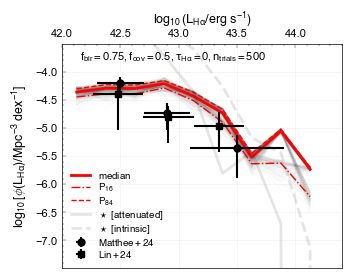

In [39]:
# top-left


# This makes sense since this figure is the first in the series.
fcov = 0.5
f_blr = 0.75
ntrials = 500

fig = plt.figure(figsize = (3.5, 2.8))

left  = 0.15
height = 0.8
bottom = 0.05
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.8, r'$\rm f_{blr}=0.75, f_{cov}=0.5, \tau_{H\alpha}=0, n_{trials}=500$', fontsize=8)

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))


# get the size
size = int(ntot * f_blr)
print(f'selected: {size}')

phi = np.empty((ntrials, nbins))

for i in range(ntrials):

    fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

    # full selection
    x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)

    N, _ = np.histogram(x, bins = bin_edges)
    
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

    Nw[Nw==0.0] = 1E-100

    phi_ = (Nw / flares.volume) / binw
    phi[i, :] = phi_

    ax.plot(bin_centres[N>4], np.log10(phi_[N>4]), c='0.5', lw=1, zorder=1, ls='-', alpha=0.01)

ax.plot(bin_centres[N>4], np.log10(np.median(phi, axis=0)[N>4]), c='r', lw=2, zorder=1, ls='-', alpha=1, label = r'$\rm median$')
ax.plot(bin_centres[N>4], np.log10(np.percentile(phi, 16., axis=0)[N>4]), c='r', lw=1, zorder=1, ls='-.', alpha=1, label = r'$\rm P_{16}$')
ax.plot(bin_centres[N>4], np.log10(np.percentile(phi, 84., axis=0)[N>4]), c='r', lw=1, zorder=1, ls='--', alpha=1, label = r'$\rm P_{84}$')
# ax.plot(bin_centres[N>4], np.log10(np.mean(phi, axis=0)[N>4]), c='k', lw=1, zorder=1, ls='--', alpha=1)


# add stellar luminosity functions
add_stellar_luminosity_function(ax, add_label=True)

# add observations
add_observations(ax, add_label=True)


ax.legend(loc='lower left', fontsize=7, labelspacing=0.1)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_realisations.pdf')
plt.show()
fig.clf()


### Different $f_{BLR}$

selected: 1601
selected: 3202
selected: 4803
selected: 6405
[[0.14 0.3  0.53]
 [0.1  0.18 0.23]]
[[0.64259354 0.46041556 0.46522203]
 [0.14489774 0.20447465 0.25213355]]


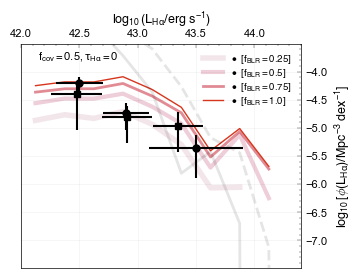

In [40]:

# top-right

# This makes sense since this figure is the first in the series.
fcov = 0.5

fig = plt.figure(figsize = (3.5, 2.8))

left  = 0.05
height = 0.8
bottom = 0.05
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.8, r'$\rm f_{cov}=0.5, \tau_{H\alpha}=0$', fontsize=8)

phi = np.empty((ntrials, nbins))

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for f_blr, lw, alpha, col in zip([0.25, 0.5, 0.75, 1.0], [4,3,2,1], [0.1, 0.2, 0.5, 1.0], colours):

    size = int(ntot * f_blr)
    print(f'selected: {size}')

    for i in range(ntrials):

        fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

        # full selection
        x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)

        N, _ = np.histogram(x, bins = bin_edges)
        
        Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

        Nw[Nw==0.0] = 1E-100

        phi_ = (Nw / flares.volume) / binw
        phi[i, :] = phi_

    ax.plot(bin_centres[N>4], np.log10(np.median(phi, axis=0)[N>4]), c=col, lw=lw, zorder=1, ls='-', alpha=alpha, label=rf'$\rm \bullet\ [f_{{BLR}}={f_blr}]$')

# add stellar luminosity functions
add_stellar_luminosity_function(ax)

# add observations
add_observations(ax)


ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.legend(fontsize=7, labelspacing=0.1)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_fblr.pdf')
plt.show()
fig.clf()

### Different $f_{cov}$

selected: 4803
selected: 4803
selected: 4803
selected: 4803
[[0.14 0.3  0.53]
 [0.1  0.18 0.23]]
[[0.64259354 0.46041556 0.46522203]
 [0.14489774 0.20447465 0.25213355]]


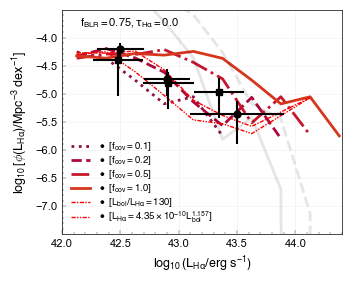

In [41]:
# lower-left


f_blr = 0.75

fig = plt.figure(figsize = (3.5, 2.8))

# left  = 0.15
# height = 0.8
# bottom = 0.15
# width = 0.8

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.8, r'$\rm f_{BLR}=0.75, \tau_{H\alpha}=0.0$', fontsize=8)

binw = 0.25
bin_edges = np.arange(42., 44.75, binw)
bin_centres = bin_edges[:-1]+binw/2


colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))

for fcov, ls, col in zip([0.1, 0.2, 0.5, 1.0], [':', '--','-.', '-',], colours):

    phi = np.empty((ntrials, nbins))

    size = int(ntot * f_blr)
    print(f'selected: {size}')

    for i in range(ntrials):

        fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

        # full selection
        x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)

        N, _ = np.histogram(x, bins = bin_edges)
        Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])
        Nw[Nw==0.0] = 1E-100
        phi_ = (Nw / flares.volume) / binw
        phi[i, :] = phi_

    ax.plot(bin_centres[N>4], np.log10(np.median(phi, axis=0)[N>4]), c=col, lw=2, zorder=1, ls=ls, label=rf'$\rm \bullet\ [f_{{cov}}={fcov}]$')



# With constant bolometric correction

x = np.log10(spectra.bolometric_luminosity[fblr_selection].to('erg/s').value) + np.log10(1./130.)

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

Nw[Nw==0.0] = 1E-100

phi = (Nw / flares.volume) / binw

ax.plot(bin_centres[N>4], np.log10(phi[N>4]), c='r', lw=1, zorder=1, ls=(0, (3, 1, 1, 1)), label=r'$\rm \bullet\ [L_{bol}/L_{H\alpha}=130]$')


# With luminosity dependent bolometric correction


def bolometric_luminosity_to_halpha_luminosity(bolometric_luminosity):
    return 5.25E42*(bolometric_luminosity/1E44/10.33)**(1.157) 

def bolometric_luminosity_to_halpha_luminosity(bolometric_luminosity):
    return 4.35E-10*(bolometric_luminosity)**(1.157) 


x = np.log10(bolometric_luminosity_to_halpha_luminosity(spectra.bolometric_luminosity[fblr_selection].to('erg/s').value))

N, _ = np.histogram(x, bins = bin_edges)
Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])

Nw[Nw==0.0] = 1E-100

phi = (Nw / flares.volume) / binw

ax.plot(bin_centres[N>4], np.log10(phi[N>4]), c='r', lw=1, zorder=1, ls=(0, (3, 1, 1, 1, 1, 1)), label=r'$\rm \bullet\ [L_{H\alpha}=4.35\times 10^{-10}L_{bol}^{1.157}]$')


# add stellar luminosity functions
add_stellar_luminosity_function(ax)

# add observations
add_observations(ax)




ax.legend(fontsize=7, labelspacing=0.1)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_fcov.pdf')
plt.show()
fig.clf()







## Add dust attenuation

selected: 4803
selected: 4803
selected: 4803
selected: 4803
[[0.14 0.3  0.53]
 [0.1  0.18 0.23]]
[[0.64259354 0.46041556 0.46522203]
 [0.14489774 0.20447465 0.25213355]]


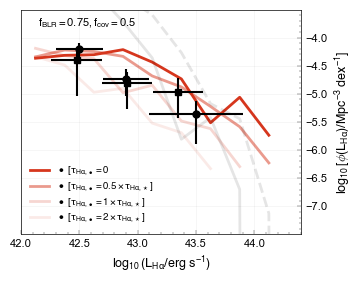

In [42]:

# bottom-right

fcov = 0.5
f_blr = 0.75


fig = plt.figure(figsize = (3.5, 2.8))

left  = 0.05
height = 0.8
bottom = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

ax.text(42.15, -3.8, r'$\rm f_{BLR}=0.75, f_{cov}=0.5$', fontsize=8)

colours = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.4, 0.6))



# Plot the line with no dust for fcov=0.5, f_blr = 0.75

phi = np.empty((ntrials, nbins))

size = int(ntot * f_blr)
print(f'selected: {size}')

for i in range(ntrials):

    fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

    # full selection
    x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)

    N, _ = np.histogram(x, bins = bin_edges)
    Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])
    Nw[Nw==0.0] = 1E-100
    phi_ = (Nw / flares.volume) / binw
    phi[i, :] = phi_

ax.plot(bin_centres[N>4], np.log10(np.median(phi, axis=0)[N>4]), c=col, lw=2, zorder=1, ls=ls, label=rf'$\rm \bullet\ [\tau_{{H\alpha, \bullet}}=0$')



# including the same attenuation as felt by the galaxy

stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s


log10fesc = np.log10(stellar_halpha_luminosity[selection]) - np.log10(intrinsic_stellar_halpha_luminosity[selection])

dust_scales = [0.5, 1, 2]

for dust_scale, alpha in zip(dust_scales, [0.5, 0.2, 0.1]):
    
    phi = np.empty((ntrials, nbins))

    size = int(ntot * f_blr)
    print(f'selected: {size}')

    for i in range(ntrials):

        fblr_selection = np.random.choice(np.arange(0, ntot), size=size, replace=False)

        # full selection
        x = np.log10(halpha_luminosity[fblr_selection].to('erg/s').value) + np.log10(fcov)  + log10fesc[fblr_selection] - np.log10(dust_scale)

        N, _ = np.histogram(x, bins = bin_edges)
        Nw, _ = np.histogram(x, bins = bin_edges, weights=weights[fblr_selection])
        Nw[Nw==0.0] = 1E-100
        phi_ = (Nw / flares.volume) / binw
        phi[i, :] = phi_
    
    ax.plot(
        bin_centres[N>4], 
        np.log10(np.median(phi, axis=0)[N>4]), 
        c=col, 
        lw=2, 
        zorder=1, 
        ls=ls, 
        alpha=alpha,
        label=rf'$\rm \bullet\ [\tau_{{H\alpha, \bullet}}={dust_scale}\times\tau_{{H\alpha, \star}}]$')



add_stellar_luminosity_function(ax)

add_observations(ax)

ax.legend(fontsize=7, labelspacing=0.25)

ax.set_xlim(X_limits)
ax.set_ylim(Y_limits)
# ax.set_xticks(np.arange(45., 46.5, 0.5))

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.set_ylabel(r'$\rm \log_{10}[\phi(L_{H\alpha})/Mpc^{-3}\ dex^{-1}]$')
ax.set_xlabel(r'$\rm \log_{10}(L_{H\alpha}/erg\ s^{-1})$')

fig.savefig(f'figures/halpha_luminosity_function_fesc.pdf')
plt.show()
fig.clf()